# **1. Introduction**

**Hi**, My name is  Zindy Yasrah Sallum, here I will create a Convolutional Neural Network (CNN) model to make a classification model to predict brain tumors.

---

## **1.1 About the dataset**

I'm going to use the dataset "Brain MRI Images for Brain Tumor Detection," which was obtained from Kaggle and uploaded by NAVONEEL CHAKRABARTY. The dataset contains MRI scan images of the human brain, classified as either tumor or normal.

* no = no tumor, encoded as 0  
* yes = tumor, encoded as 1

Dataset Link : _https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection_

---

## **1.2 Brief Explanation about the topics**

> ### **What is Brain Tumor?**

A brain tumor is a growth of cells in the brain or near it. Brain tumors can happen in the brain tissue. Brain tumors also can happen near the brain tissue. Nearby locations include nerves, the pituitary gland, the pineal gland, and the membranes that cover the surface of the brain.

> ### **What is MRI?**

_Magnetic resonance imaging (MRI)_ is a medical imaging technique that uses a magnetic field and computer-generated radio waves to create detailed images of the organs and tissues in your body.

Most MRI machines are large, tube-shaped magnets. When you lie inside an MRI machine, the magnetic field temporarily realigns water molecules in your body. Radio waves cause these aligned atoms to produce faint signals, which are used to create cross-sectional MRI images — like slices in a loaf of bread.

_source : www.mayoclinic.org_

---


## **1.3 Background**

**Can You See the MRI Results Immediately?**

Unlike some medical tests, MRI results are not immediately available after the scan. They generate the images through an MRI scan which the radiologist interprets. A physician with specific training in using medical imaging technologies to identify and treat diseases is known as a radiologist.

The radiologist will review the images and create a report detailing their findings. They send the report to your doctor or the healthcare provider who ordered the scan. The report may include images, descriptions of abnormalities or injuries, and recommendations for further testing or treatment.

_Source : https://aqmdi.com/how-long-does-it-take-to-get-mri-results/_

So, there are a lot of processes before the patient can receive the result. What if we could provide a faster response by creating an image classification system, so that after the scan results are out, the patient knows the result immediately.

---



## **1.4 Objective**

We will assist medical personnel by creating a Convolutional Neural Network (CNN) model to classify brain tumors from MRI scan results and predict the difference between tumorous brains and normal brains.

---

# 2. **Import Libraries**

In [234]:
!pip install tensorflow-addons

In [235]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# **3. Data Loading**

In [236]:
# Authenticating google drive to colab notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [237]:
# change the directory to the dataset in drive folder
main_path= '/content/drive/MyDrive/brain_tumor_dataset'

# Check the folder inside the main path
os.listdir(main_path)

['yes', 'no']

There are two folders. the "yes" folder, which consists of MRI scan images of tumorous brains, and the "no" folder, which consists of MRI scan images of normal brains.

# **4. Exploratory Data Analysis (EDA)**

First thing first, we need to visualize those images so that we know how brain MRI scan results looks like.

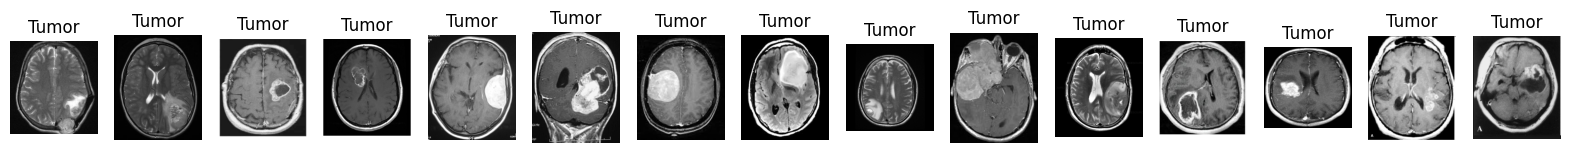

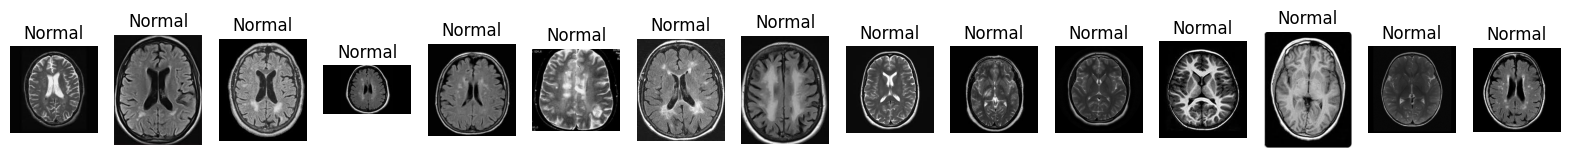

In [238]:
yes = '/content/drive/MyDrive/brain_tumor_dataset/yes'
no =  '/content/drive/MyDrive/brain_tumor_dataset/no'

sub=1
plt.figure(figsize=(20, 10))
for i in range(15):
  plt.subplot(1, 15, sub)
  sub +=1
  plt.imshow(load_img(os.path.join(yes , os.listdir(yes)[i])))
  plt.title('Tumor')
  plt.axis('off')
plt.show()

sub=1
plt.figure(figsize=(20, 10))
for i in range(15):
  plt.subplot(1, 15, sub)
  sub +=1
  plt.imshow(load_img(os.path.join(no , os.listdir(no)[i])))
  plt.title('Normal')
  plt.axis('off')
plt.show()

Okay, so it looks like we have different sizes of images, and I think we only have 1 channel of color, which is grayscale. However, we do have one image that has a different angle from other images. I found it by checking the images one by one. Below, I will display that particular image.

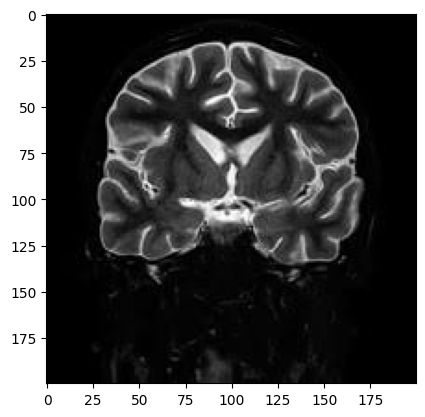

In [239]:
plt.imshow(load_img('/content/drive/MyDrive/brain_tumor_dataset/no/19 no.jpg'))

this one particular image have a different angle and it looks like scanned from back or maybe front?

Alright so after a little bit of research i found something in this journal from "AL-Hussain University College" Authored by Mohammed J. Alwazzan*

(_Source:https://www.researchgate.net/publication/334899355_Brain_Tumour_Isolation_in_MRI_Images_Based_on_Statistical_Properties_and_Morphological_Process_Techniques_)

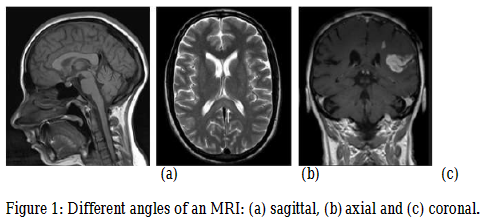

From the journal, they said there are 3 types of brain MRI scan, which are sagittal, axial and coronal.

Basically sagittal is scanned from sides, axial from top and coronal from back.

i have discovered that in our dataset (by manually checking the images one by one), it is only consist of axial images, and one coronal images without any sagittal image. Since we only have 1 coronal images, i think it is better to drop that one particular coronal image.

In [240]:
coronal = ('/content/drive/MyDrive/brain_tumor_dataset/no/19 no.jpg')

# Check if the file exists before attempting to delete
if os.path.exists(coronal):
    # Delete the image file
    os.remove(coronal)
    print(f"The image {coronal} has been deleted.")
else:
    print(f"The image {coronal} does not exist.")

The image /content/drive/MyDrive/brain_tumor_dataset/no/19 no.jpg has been deleted.


Okay, now that we delete that one particular coronal image, it means that the dataset now only consist of axial scan images. Since the model will be trained in this particular type of MRI scan, it means that the model cannot predict MRI scan images of sagittal and coronal types accurately.

last we are going to see the average image size or the resolution. since i don't know how big MRI scan image size resolution can be, it will be nice to know what are the average size in this dataset

In [241]:
# Function to calculate the average size for a given folder
def average(folder_path):
    # Get a list of all files in the folder
    all_files = os.listdir(folder_path)

    # Initialize variables to store total width and height
    total_width = 0
    total_height = 0
    num_images = 0

    # Loop through the files, load images, and calculate the total width and height
    for file in all_files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG')):
            img_path = os.path.join(folder_path, file)
            img = Image.open(img_path)
            width, height = img.size
            total_width += width
            total_height += height
            num_images += 1

    # Calculate the average size for the folder
    if num_images > 0:
        average_width = total_width / num_images
        average_height = total_height / num_images

        print(f"Average Width for {folder_path}: {round(average_width)}px x {round(average_height)}px")
    else:
        print(f"No images found with the specified extensions in {folder_path}.")


# Call the function for each folder
average(yes)
average(no)

Average Width for /content/drive/MyDrive/brain_tumor_dataset/yes: 361px x 414px
Average Width for /content/drive/MyDrive/brain_tumor_dataset/no: 348px x 349px


We can see that the average sizes of images is around 350px x 380px -ish

# **5. Feature Engineering**

Here im going to use pipeline `tf.keras.utils.image_dataset_from_directory`, so basically it will do any hard work in one package, will made life so much easier. It will batch the image (default 32), resize the image with default value of (256 x 256), also this function will create a label based on the folder. And for the color mode the default is rgb, we dont want that becauase MRI scan images only have one channels of color which is grayscale, hence we will change the color_mode to grayscale.

In [242]:
data = tf.keras.utils.image_dataset_from_directory(main_path, color_mode='grayscale')

Found 249 files belonging to 2 classes.


But we do have downside, we cant just grab the data inside the pipeline. To fix this problem we are going to use numpy iterator. This will allow us to visualize the images inside the pipeline to make sure that this pipeline made the label correctly

In [243]:
data_iterator = data.as_numpy_iterator()

# Get one batch from the iterator
batch = data_iterator.next()
len(batch)

2

As you can see there, we are taking a single batch from the data pipeline. the batch consist of 2 things which are the images and the label. lets see the first index of batch (should consist images)

In [244]:
print('Shape : ',batch[0].shape)

Shape :  (32, 256, 256, 1)


There are 32 images in this batch, and their size has been rescaled to 256x256 with 1 channel of color.

Now, how does this pipeline label which images belong to which labels? from the documentation they said that it depends on the folder structure, so the first folder is labelled 0 and the second folder is labelled 1

However, if the folder structure were inverted, we could use `labels='inferred'`. But in our case, the folders are in the correct position. To make sure, let's visualize the images from this batch.

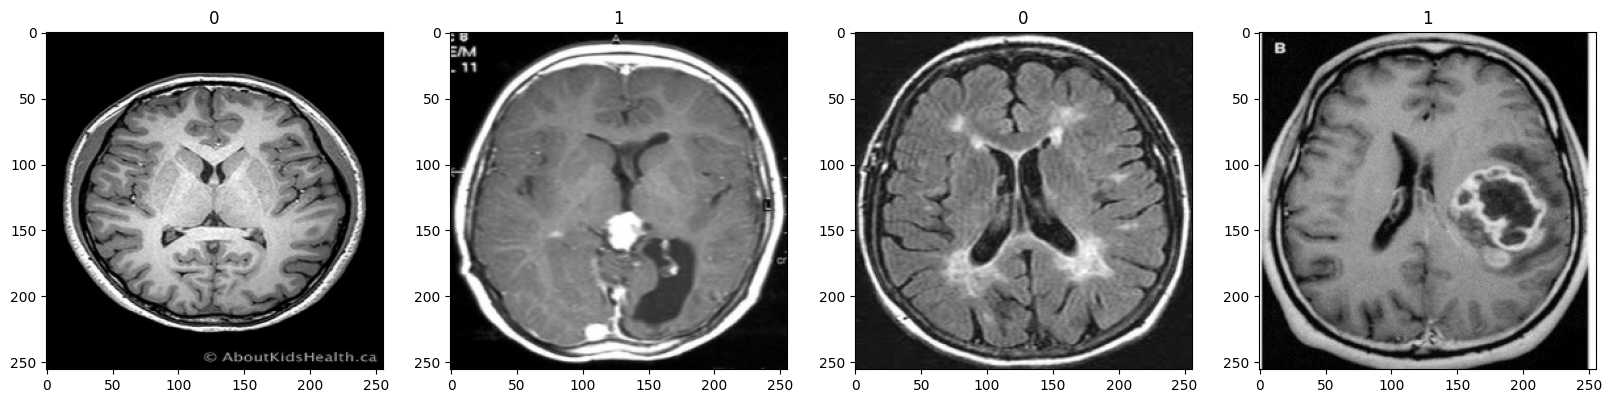

In [245]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int), cmap='gray')
    ax[i].title.set_text(batch[1][i])

Even without any expertise in this field, we can clearly see that the corresponding label made by the pipeline is correct. We can see the picture that labelled as 1 (tumor) have some white-ish and black color of weird shapes (the tumor). As for the picture that labelled 0, we can see a clean brain images.

## **5.1 Data Scaling**

Because we are using the TensorFlow pipeline here, we are going to use the map function, The `map()` function in TensorFlow's `tf.data.Dataset` basically allows us to apply a function to each element of the dataset, transforming the elements into new ones.

In [246]:
data = data.map(lambda x,y: (x/255, y))

Here, x will represent our images and y will represent the label, we will scale the image from 0 to 1 by dividing each element by 255. As for the label we will not do anything since the label is already in binary format (0 and 1)

## **5.2 Data Splitting**

In [247]:
len(data)

8

So here we have 8 batches of data, we will divide them into 4:2:2, Train-set, Validation set, and test set respectively.

In [248]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.3)
test_size = int(len(data)*.3)

print('Train Batch Size :',train_size)
print('Validation Batch Size :',val_size)
print('Test Batch Size :',test_size)

Train Batch Size : 4
Validation Batch Size : 2
Test Batch Size : 2


Now, in `tf.data.Dataset` i've found some interesting function which are `take` and `skip`,

first one `take`, so this method creates a new dataset containing the first count elements of the original dataset. It allows us to extract a fixed number of elements from the beginning of the dataset.

the second one is `skip`, This method creates a new dataset by skipping the first count elements of the original dataset. It allows us to exclude a fixed number of elements from the beginning of the dataset.

so for the train set, we are going to use `take()` and get the batch size from earlier. as for the validation we are going to use `skip()` first and then we can take a new set of data using `take()` and also the same thing for test-set we will use `skip()` and then `take()`

In [249]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [250]:
train_batch = tf.data.experimental.cardinality(train).numpy()
val_batch = tf.data.experimental.cardinality(val).numpy()
test_batch = tf.data.experimental.cardinality(test).numpy()

print(f"Total batch in the 'train' dataset: {train_batch}")
print(f"Total batch in the 'val' dataset: {val_batch}")
print(f"Total batch in the 'test' dataset: {test_batch}")

Total batch in the 'train' dataset: 4
Total batch in the 'val' dataset: 2
Total batch in the 'test' dataset: 2


# **6. Model Definition**

First, im gonna create a simple baseline model, this model will consist of 2 layers, the first one have 16 filters with kernel size of 5x5 and stride of 3, means the kernel moves 3 pixel at a time in both the vertical and horizontal directions. and the second layer have 8 filters.

as for the activation function im going to use `elu`, or Exponential Linear Unit. The ELU function have the ability to handle negative values with a gentle slope helps overcome some of the limitations of the Rectified Linear Unit (ReLU) activation, which can cause neurons to become inactive or "die" during training if they consistently receive negative gradients.

For the `input_shape` i will change it to (256, 256, 1), indicating that the model expects grayscale images with a resolution of 256x256 pixels.

In [251]:
model = Sequential()

model.add(Conv2D(16, (5,5), 3, activation='elu', padding='same', input_shape=(256,256,1)))
model.add(MaxPooling2D())

model.add(Conv2D(8, (5,5), 3, activation='elu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='elu'))
model.add(Dense(1, activation='sigmoid'))

In [252]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [253]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 86, 86, 16)        416       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 43, 43, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 15, 15, 8)         3208      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 392)               0         
                                                                 
 dense_24 (Dense)            (None, 256)             

# **7. Model Training**

We will train the model with 20 epochs

In [254]:
%%time

history = model.fit(
    train,
    epochs=20,
    validation_data=val
)

Epoch 1/20
4/4 [==============================] - 4s 397ms/step - loss: 0.6573 - accuracy: 0.5391 - val_loss: 0.6962 - val_accuracy: 0.5156
Epoch 2/20
4/4 [==============================] - 4s 895ms/step - loss: 0.6060 - accuracy: 0.6406 - val_loss: 0.5472 - val_accuracy: 0.6875
Epoch 3/20
4/4 [==============================] - 2s 298ms/step - loss: 0.5704 - accuracy: 0.7812 - val_loss: 0.5459 - val_accuracy: 0.7656
Epoch 4/20
4/4 [==============================] - 2s 348ms/step - loss: 0.5187 - accuracy: 0.7891 - val_loss: 0.5943 - val_accuracy: 0.7500
Epoch 5/20
4/4 [==============================] - 2s 450ms/step - loss: 0.4860 - accuracy: 0.7812 - val_loss: 0.5225 - val_accuracy: 0.8281
Epoch 6/20
4/4 [==============================] - 2s 444ms/step - loss: 0.5372 - accuracy: 0.7734 - val_loss: 0.5175 - val_accuracy: 0.7188
Epoch 7/20
4/4 [==============================] - 3s 493ms/step - loss: 0.4570 - accuracy: 0.7891 - val_loss: 0.5627 - val_accuracy: 0.7188
Epoch 8/20
4/4 [====

# **8. Model Evaluation**

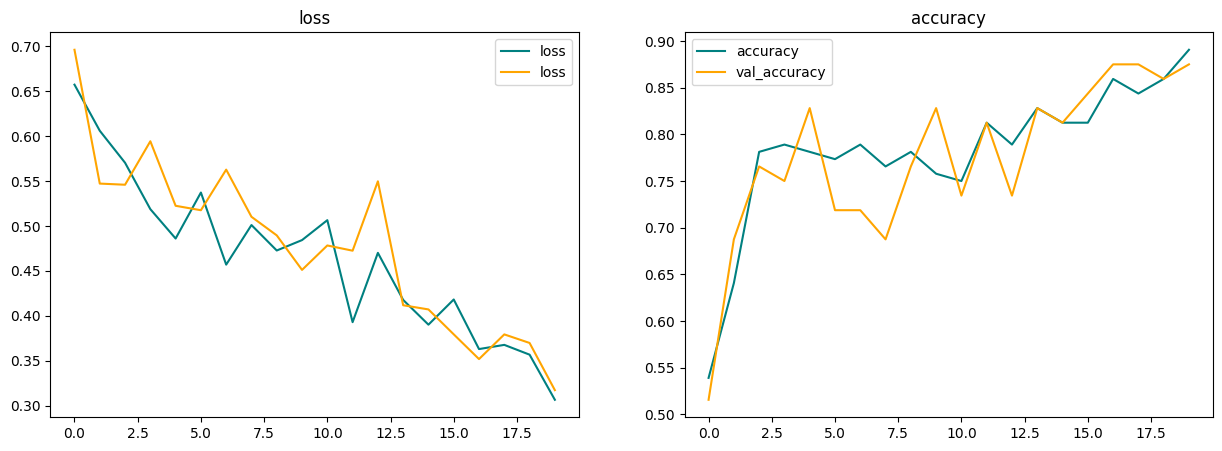

In [255]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [256]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

1/1 [==============================] - 0s 72ms/step


In [257]:
print(f'Precision : {precision.result()}')
print(f'Recall : {recall.result()}')
print(f'Accuracy : {accuracy.result()}')

Precision : 0.7749999761581421
Recall : 0.96875
Accuracy : 0.8245614171028137


clearly we can't give this model to our medical client. We don't want the model misclassify any class, Both precision and recall are essential in medical diagnosis scenarios like this.

High precision ensures that the model does not misclassify healthy brain scans as having tumors, reducing unnecessary concerns and follow-up tests for patients.

High recall ensures that the model detects a significant portion of brain scans with tumors, This reduces the chance of missing cases where a tumor is actually present, allowing doctors to act quickly and provide faster treatment.

Let's see the peformance of this model against train and validation sets.

In [258]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in train.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Train-Set) : {precision.result()}')
print(f'Recall (Train-Set) : {recall.result()}')
print(f'Accuracy (Train-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 22ms/step
Precision (Train-Set) : 0.8804348111152649
Recall (Train-Set) : 0.9759036302566528
Accuracy (Train-Set) : 0.8984375


In [259]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in val.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Validation-Set) : {precision.result()}')
print(f'Recall (Validation-Set) : {recall.result()}')
print(f'Accuracy (Validation-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 24ms/step
Precision (Validation-Set) : 0.9069767594337463
Recall (Validation-Set) : 0.9750000238418579
Accuracy (Validation-Set) : 0.921875


We can see that there is no noticeable gap in those scores, which means the model is actually considered a good-fit. However, we can still improve the performance

# **ANN Improvement**

Since we only have a small sample of images in our dataset, i'm afraid that the model didn't get enough training sample to make a good prediction, to make the model more powerful i think we can implement transfer learning.

In transfer learning, the idea is to take advantage of the features and representations learned by a pre-trained model when dealing with the new task. This approach is especially beneficial when the target task has limited data, as the pre-trained model has already learned useful patterns from a more extensive dataset.

the pre-trained model we are going to use is `VGG16`, because it is a powerful and has been widely used. It has a simple structure, making it easy to implement and understand. VGG16's versatility and proven performance make it a popular choice for various image recognition tasks.

so to increase model performance, i will use pretrained model `VGG16`  and then add more layers on top of that. Also i will change the activation function to `relu`

In [260]:
data = tf.keras.utils.image_dataset_from_directory(main_path)

data = data.map(lambda x,y: (x/255, y))
train_size = int(len(data)*.6)
val_size = int(len(data)*.3)
test_size = int(len(data)*.3)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 249 files belonging to 2 classes.


In [261]:
# Load the pre-trained VGG16 model
vgg_model = VGG16(
weights='imagenet',
include_top=False,
input_shape=(256,256,3)
)

# Create a new model by adding a few layers on top of the pre-trained model
model = Sequential()
model.add(vgg_model)

model.add(Conv2D(16, (3,3),1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [262]:
%%time

history_vgg = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=[early_stopping]
)

Epoch 1/30
4/4 [==============================] - 6s 604ms/step - loss: 0.6624 - accuracy: 0.6250 - val_loss: 0.6013 - val_accuracy: 0.6875
Epoch 2/30
4/4 [==============================] - 2s 486ms/step - loss: 0.6556 - accuracy: 0.6328 - val_loss: 0.6124 - val_accuracy: 0.6562
Epoch 3/30
4/4 [==============================] - 2s 489ms/step - loss: 0.6421 - accuracy: 0.5703 - val_loss: 0.6251 - val_accuracy: 0.5469
Epoch 4/30
4/4 [==============================] - 3s 619ms/step - loss: 0.6144 - accuracy: 0.5859 - val_loss: 0.5378 - val_accuracy: 0.6875
Epoch 5/30
4/4 [==============================] - 3s 623ms/step - loss: 0.5420 - accuracy: 0.6562 - val_loss: 0.5494 - val_accuracy: 0.7344
Epoch 6/30
4/4 [==============================] - 2s 519ms/step - loss: 0.4774 - accuracy: 0.7891 - val_loss: 0.4844 - val_accuracy: 0.7969
Epoch 7/30
4/4 [==============================] - 2s 497ms/step - loss: 0.3899 - accuracy: 0.8906 - val_loss: 0.3978 - val_accuracy: 0.8281
Epoch 8/30
4/4 [====

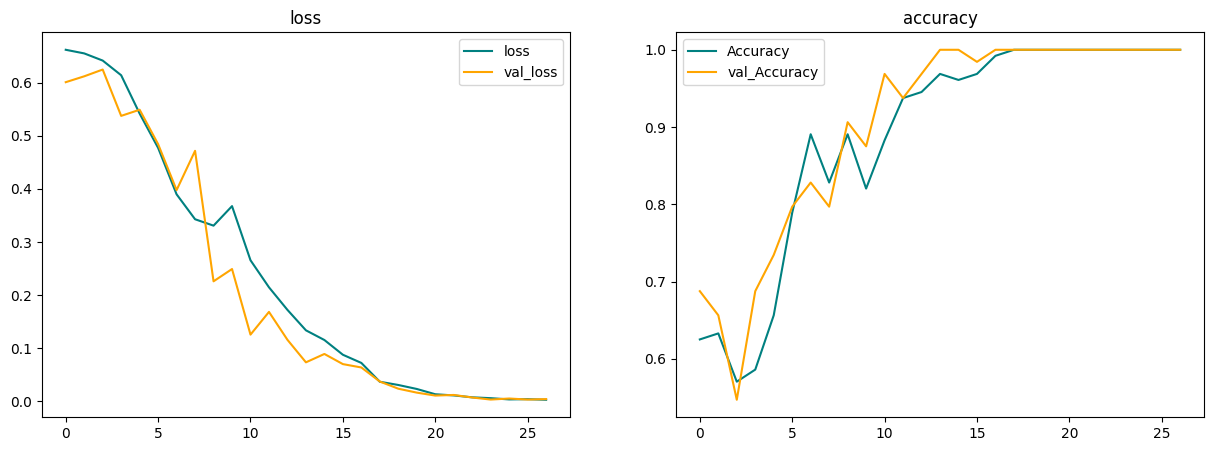

In [263]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_vgg.history['loss'], color='teal', label='loss')
plt.plot(history_vgg.history['val_loss'], color='orange', label='val_loss')
plt.title('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_vgg.history['accuracy'], color='teal', label='Accuracy')
plt.plot(history_vgg.history['val_accuracy'], color='orange', label='val_Accuracy')
plt.title('accuracy')
plt.legend()
plt.show()

In [264]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Test-Set) : {precision.result()}')
print(f'Recall (Test-Set) : {recall.result()}')
print(f'Accuracy (Test-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 184ms/step
Precision (Test-Set) : 1.0
Recall (Test-Set) : 1.0
Accuracy (Test-Set) : 1.0


In [265]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in train.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Train-Set) : {precision.result()}')
print(f'Recall (Train-Set) : {recall.result()}')
print(f'Accuracy (Train-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 40ms/step
Precision (Train-Set) : 1.0
Recall (Train-Set) : 1.0
Accuracy (Train-Set) : 1.0


In [266]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

for batch in val.as_numpy_iterator():
  X, y = batch
  y_pred = model.predict(X)
  precision.update_state(y, y_pred)
  recall.update_state(y, y_pred)
  accuracy.update_state(y, y_pred)

print(f'Precision (Validation-Set) : {precision.result()}')
print(f'Recall (Validation-Set) : {recall.result()}')
print(f'Accuracy (Validation-Set) : {accuracy.result()}')

1/1 [==============================] - 0s 42ms/step
Precision (Validation-Set) : 1.0
Recall (Validation-Set) : 1.0
Accuracy (Validation-Set) : 1.0


With the added pretrained model `VGG16`, we achieved perfect predictions for precision, recall, and accuracy in all score for test, train and validation set with increase training time from around 50sec to 1m 30sec.

To make sure it is not "too good to be true" let's find out in the confusion matrix below

In [267]:
tp_count, fp_count, tn_count, fn_count = 0, 0, 0, 0

for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)

    # Round the probabilities to get binary predictions (0 or 1)
    y_pred_binary = np.round(y_pred).astype(int)

    # Calculate true positive, false positive, true negative, and false negative counts
    for true_label, pred_label in zip(y, y_pred_binary):
        if true_label == 1 and pred_label == 1:
            tp_count += 1
        elif true_label == 0 and pred_label == 1:
            fp_count += 1
        elif true_label == 1 and pred_label == 0:
            fn_count += 1
        elif true_label == 0 and pred_label == 0:
            tn_count += 1

# Print confusion matrix and performance metrics
print(f'Confusion Matrix:')
print(f'True Negatives: {tn_count}, False Positives: {fp_count}')
print(f'False Negatives: {fn_count}, True Positives: {tp_count}')

1/1 [==============================] - 0s 31ms/step
Confusion Matrix:
True Negatives: 29, False Positives: 0
False Negatives: 0, True Positives: 28


We can see that from 57 samples of MRI scan images, the model can classify every sample into the right class.

# **9. Model Saving**

In [268]:
# Freeze Model
model.trainable = False
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_33 (Conv2D)          (None, 8, 8, 16)          73744     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 4, 4, 32)          4640      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 2, 2, 16)        

In [269]:
# Save Model
model.save(os.path.join('deployment','brain_tumor.h5'))

# **10. Conclusion**

We can see that in the last training session with the pretrained model `VGG16`, the model achieved a perfect prediction against the test set. It means the model correctly classified all the images into the right classes, but we did experience an increase in the training time. However, in this medical scenario, an increased training time is far better than misclassifying a class.

## **Further Improvement**
For further improvement, we acknowledge that this model is only trained with axial scan results (refer to the first session of this notebook). Therefore, if the model is given a sagittal or coronal scan result, it is likely to provide incorrect or even random predictions. To address this, we can augment our dataset with more sagittal and coronal images so that the model can learn from those types of scans as well.

As a side project, I'm interested in adding more features. I am planning to create another model that can mask the actual tumor in MRI scan images using Mask R-CNN. The scenario will be as follows: First, this model will classify whether the scan result shows a tumor or not. After that, if there is a tumor present, it will pinpoint or mask the tumor area, making it easier to precisely identify the location of the tumor.